In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

In [4]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_72807/4026766541.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 128/128 [00:00<00:00, 435.52it/s]


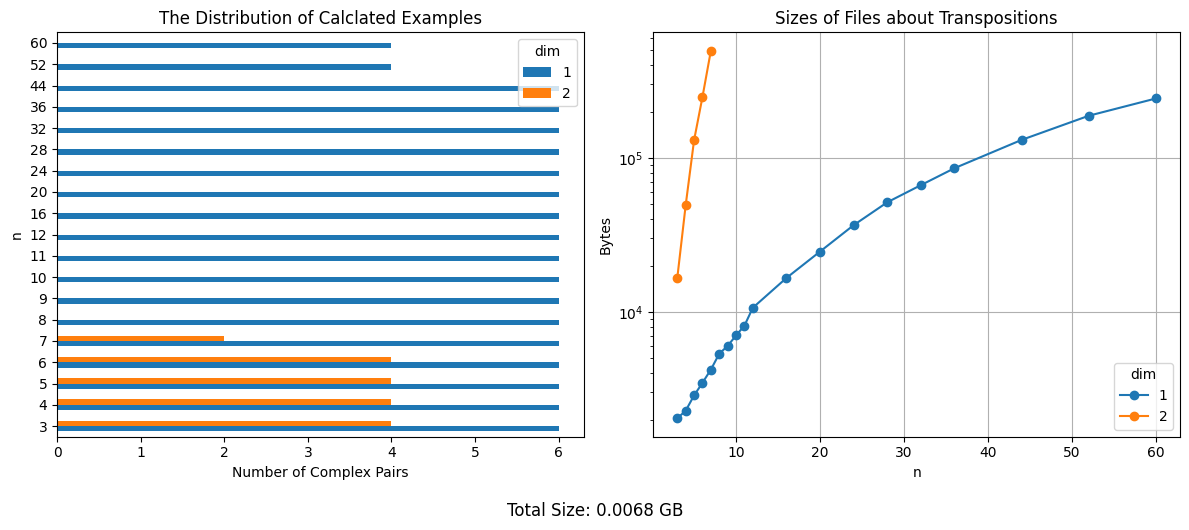

In [5]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

In [6]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 128/128 [00:00<00:00, 529.13it/s]


df.shape = (52363, 24)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,...,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-06-18 16:08:54.771944,2025-06-18 16:08:54.761551,1,4,"(4,)",0.143622,0.898951,0.0,1.0,0.0,...,1.0,0.0,1.0,2,3,"((3,),)","((0,),)",0,birth-birth,switch forward
1,2025-06-18 16:08:54.771944,2025-06-18 16:08:54.761551,1,4,"(4,)",0.280993,1.746056,0.0,1.0,0.0,...,1.0,0.0,1.0,6,7,"((2,), (3,))","((0,), (1,))",1,death-unpaired,undefined
2,2025-06-18 16:08:54.771944,2025-06-18 16:08:54.761551,1,4,"(4,)",0.570875,1.571011,0.0,0.0,1.0,...,0.2,0.0,0.0,5,6,"((3,), (0,))","((0,), (1,))",1,death-death,no switch
3,2025-06-18 16:08:54.771944,2025-06-18 16:08:54.761551,1,4,"(4,)",0.977345,0.430177,1.0,1.0,1.0,...,1.0,1.0,1.0,0,1,"((2,),)","((1,),)",0,birth-unpaired,undefined
4,2025-06-18 16:08:54.771944,2025-06-18 16:08:54.761551,1,4,"(4,)",0.998069,0.431932,1.0,1.0,1.0,...,0.2,1.0,1.0,1,2,"((2,),)","((0,),)",0,birth-birth,no switch


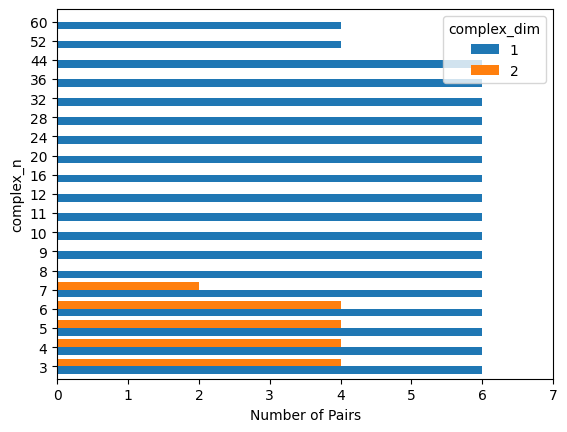

In [7]:
df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n']
           )['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().pivot_table(columns='complex_dim', index='complex_n', values='complex_index0').fillna(0).astype(int).plot(kind='barh', width=0.8)

plt.xlabel('Number of Pairs')
xticks, _ = plt.xticks()
xticks = np.unique(np.array(xticks).astype(int))
plt.xticks(xticks)

plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_72807/2076783452.py:19: SyntaxWarning: invalid escape sequence '\;'
  axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')


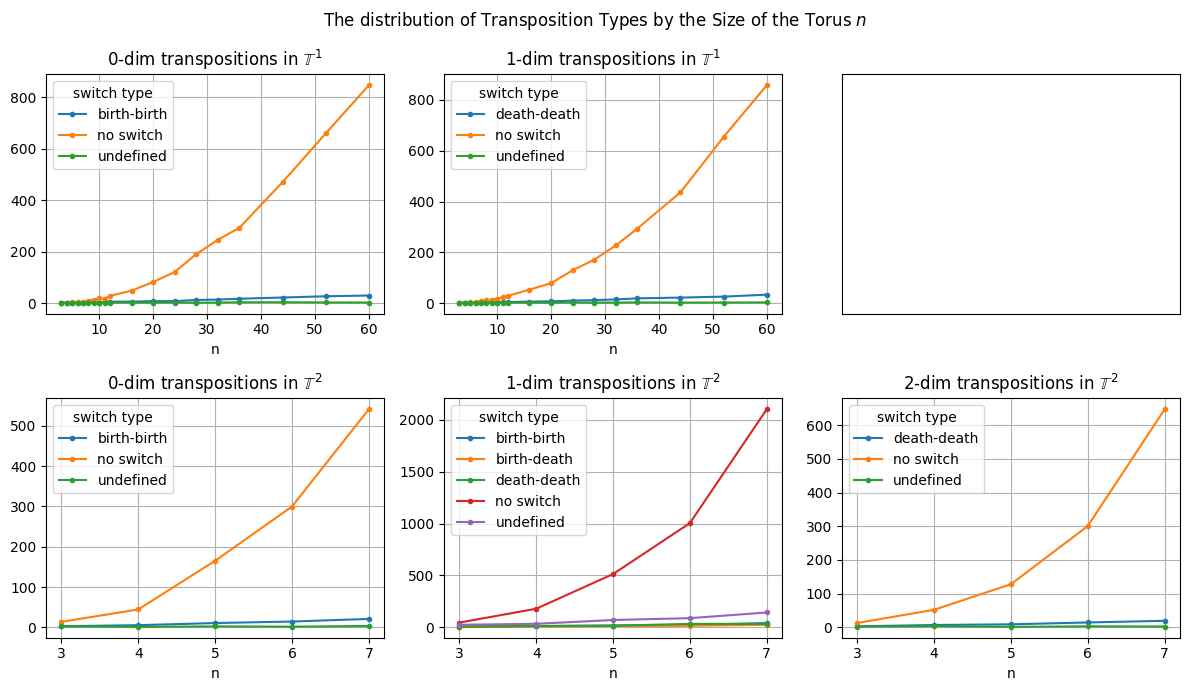

In [8]:
df_switch_types = df.copy()

df_switch_types.loc[(df_switch_types['switch'] == 'switch forward') | (df_switch_types['switch'] == 'switch backward'), 'switch'] = 'switch'
df_switch_types['switch type'] = df_switch_types.apply(lambda row: row['type'] if row['switch'] == 'switch' else row['switch'], axis=1)

df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
df_switch_types = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
df_switch_types = df_switch_types.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1), squeeze=False)
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$')
for i, complex_dim in enumerate(complex_dims):
    for j, transposition_dim in enumerate(transposition_dims):
        try:
            df_switch_types[complex_dim][transposition_dim].plot(ax=axs[i, j], marker='.')
            axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
            axs[i, j].grid(True)
            axs[i, j].set_xlabel('n')
        except KeyError:
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
plt.tight_layout()


In [26]:
df[['dim', 'type', 'switch']].value_counts().reset_index().pivot_table(columns=['dim', 'switch'], index='type', values='count').fillna(0).astype(int)

dim                       0                                           \
switch            no switch switch backward switch forward undefined   
type                                                                   
birth-birth           18498             526            511         0   
birth-death               0               0              0         0   
birth-unpaired            0               0              0       219   
death-death               0               0              0         0   
death-unpaired            0               0              0         0   
unpaired-unpaired         0               0              0         0   

dim                       1                                           \
switch            no switch switch backward switch forward undefined   
type                                                                   
birth-birth            4737             140            141         0   
birth-death            1737               0            171         0   
birth-unpaired            0               0              0       550   
death-death           19718             599            593         0   
death-unpaired            0               0              0       719   
unpaired-unpaired         0               0              0        38   

dim                       2                                           
switch            no switch switch backward switch forward undefined  
type                                                                  
birth-birth               0               0              0         0  
birth-death               0               0              0         0  
birth-unpaired            0               0              0         0  
death-death            3266              79             85         0  
death-unpaired            0               0              0        36  
unpaired-unpaired         0               0              0         0

In [27]:
df[df['switch'] == 'undefined'][['dim', 'type']].value_counts().reset_index().pivot_table(index='type', columns='dim', values='count').fillna(0).astype(int)

dim,0,1,2
type,,,
birth-unpaired,219,550,0
death-unpaired,0,719,36
unpaired-unpaired,0,38,0
